In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import time
import FinanceDataReader as fdr

In [23]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D

In [4]:
pd.read_csv('./data/적자기업모델데이터/APS홀딩스_모델데이터.csv',index_col=0).head()

,Date,Close,Volume,Change,MACD,MACD_Signal,MACD_Oscilator,%K,%D,upper_b,...,bar_length,High-Close,High-Open,High-Low,Close-Open,Close-Low,Open-Low,KQ_Change,ND_Change,SP_Change
0,2014-01-29,7004,376760,0.001144,6987.929331,6982.637707,5.291624,24.242424,15.584416,7469.612922,...,59.0,163.0,104.0,164,-59.0,1.0,60.0,0.0116,-0.0114,0.0061
1,2014-02-03,6966,282414,-0.005425,6984.451415,6982.805361,1.646054,24.832215,23.861821,7452.879467,...,45.0,179.0,224.0,246,45.0,67.0,22.0,-0.0031,-0.0114,0.0061
2,2014-02-04,6788,489413,-0.025553,6953.442205,6980.140055,-26.697850,0.490196,16.358213,7430.813515,...,16.0,74.0,90.0,120,16.0,46.0,30.0,-0.0118,-0.0261,-0.0065
3,2014-02-05,6795,288790,0.001031,6928.532277,6975.532523,-47.000247,3.240741,9.357652,7407.573488,...,52.0,134.0,82.0,157,-52.0,23.0,75.0,-0.0038,0.0086,-0.0228
4,2014-02-06,6869,417029,0.010890,6919.204196,6970.578866,-51.374670,37.500000,13.580247,7379.493057,...,67.0,67.0,134.0,142,67.0,75.0,8.0,0.0084,-0.0050,0.0076


# 함수화

## 모델 함수화: model_xy

In [88]:
def model_xy(df, window_size, target_size, rapid_rate):  # df index_col=0 해줘야함
    X = []
    Y = []

    for i in range(len(df)-window_size-target_size):
        # feature
        X.append([df.iloc[i+j,4:] for j in range(window_size)])

        # Change
        Y.append([df.iloc[window_size+i+j,3] for j in range(target_size)])

    Y1 = []

    # 7%이상 상승일시
    for y in Y:
        toggle = 0

        for i in y:
            if i >= rapid_rate:
                Y1.append(1)
                toggle = 1
                break


        if toggle!=1:
            Y1.append(0)

    X = np.array(X).astype(float)
    Y1 = np.array(Y1).astype(float)
    
    return X, Y1



## 결과 그래프함수화

In [105]:
def result_loss(hist):
    plt.plot(hist.history['loss'],label='loss')
    plt.plot(hist.history['val_loss'],label='val_loss')
    plt.legend(loc = 'upper left')
    
def result_acc(hist):
    plt.plot(hist.history['accuracy'],label='accuracy')
    plt.plot(hist.history['val_accuracy'],label='val_accuracy')
    plt.legend(loc = 'upper left')

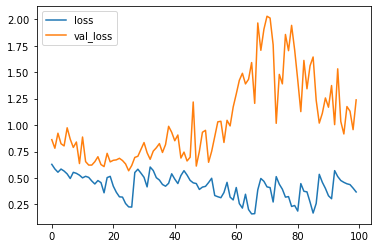

In [106]:
result_loss(hist2)

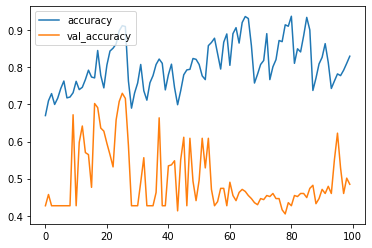

In [107]:
result_acc(hist2)

# 모델 돌리기

## 딥러닝1

In [7]:
file_list = os.listdir('./data/적자기업모델데이터/')

In [9]:
file_list[0]

'APS홀딩스_모델데이터.csv'

In [50]:
df = pd.read_csv('./data/적자기업모델데이터/시티랩스_모델데이터.csv',index_col=0)

window_size = 250
target_size = 30

X = []
Y = []

for i in range(len(df)-window_size-target_size):
    # feature
    X.append([df.iloc[i+j,4:] for j in range(window_size)])

    # Change
    Y.append([df.iloc[window_size+i+j,3] for j in range(target_size)])

Y1 = []

# 7%이상 상승일시
for y in Y:
    toggle = 0

    for i in y:
        if i >= 0.1:
            Y1.append(1)
            toggle = 1
            break
    

    if toggle!=1:
        Y1.append(0)

X = np.array(X).astype(float)
Y1 = np.array(Y1).astype(float)
    

In [51]:
X.shape

(1663, 250, 22)

In [52]:
Y1.shape

(1663,)

In [53]:
train_test_split = 1300

x_train = X[:1300]
y_train = Y1[:1300]

x_test = X[1300:]
y_test = Y1[1300:]

In [54]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50, input_shape=(250,22)))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               49200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________


In [55]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', metrics ='accuracy', optimizer=Adam)

In [56]:
hist = model.fit(x_train, y_train, epochs=100, batch_size= 10, validation_data= (x_test,y_test))

Epoch 1/100
130/130 [==============================] - 3s 13ms/step - loss: 0.7416 - accuracy: 0.5131 - val_loss: 0.7009 - val_accuracy: 0.5730
Epoch 2/100
130/130 [==============================] - 1s 11ms/step - loss: 0.6731 - accuracy: 0.6292 - val_loss: 0.6764 - val_accuracy: 0.5730
Epoch 3/100
130/130 [==============================] - 1s 11ms/step - loss: 0.6611 - accuracy: 0.6292 - val_loss: 0.6732 - val_accuracy: 0.5730
Epoch 4/100
130/130 [==============================] - 1s 11ms/step - loss: 0.6523 - accuracy: 0.6292 - val_loss: 0.6555 - val_accuracy: 0.5730
Epoch 5/100
130/130 [==============================] - 1s 11ms/step - loss: 0.6461 - accuracy: 0.6292 - val_loss: 0.6590 - val_accuracy: 0.5730
Epoch 6/100
130/130 [==============================] - 1s 11ms/step - loss: 0.6404 - accuracy: 0.6292 - val_loss: 0.6495 - val_accuracy: 0.5730
Epoch 7/100
130/130 [==============================] - 1s 11ms/step - loss: 0.6352 - accuracy: 0.6292 - val_loss: 0.6561 - val_accuracy:

In [57]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

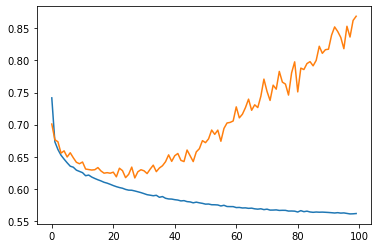

In [58]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

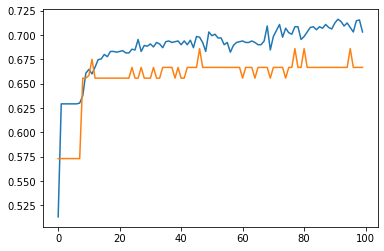

In [59]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

##  시티랩스 250 30 10%

In [61]:
df = pd.read_csv('./data/적자기업모델데이터/시티랩스_모델데이터_scaler.csv',index_col=0)

window_size = 250
target_size = 30

X = []
Y = []

for i in range(len(df)-window_size-target_size):
    # feature
    X.append([df.iloc[i+j,4:] for j in range(window_size)])

    # Change
    Y.append([df.iloc[window_size+i+j,3] for j in range(target_size)])

Y1 = []

# 7%이상 상승일시
for y in Y:
    toggle = 0

    for i in y:
        if i >= 0.1:
            Y1.append(1)
            toggle = 1
            break
    

    if toggle!=1:
        Y1.append(0)

X = np.array(X).astype(float)
Y1 = np.array(Y1).astype(float)
    

In [62]:
X.shape

(1663, 250, 22)

In [63]:
train_test_split = 1300

x_train = X[:1300]
y_train = Y1[:1300]

x_test = X[1300:]
y_test = Y1[1300:]

In [64]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50, input_shape=(250,22)))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                14600     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________


In [67]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', metrics ='accuracy', optimizer=Adam)

In [68]:
hist = model.fit(x_train, y_train, epochs=100, batch_size= 10, validation_data= (x_test,y_test))

Epoch 1/100
130/130 [==============================] - 3s 12ms/step - loss: 0.6366 - accuracy: 0.6331 - val_loss: 0.7191 - val_accuracy: 0.4601
Epoch 2/100
130/130 [==============================] - 1s 9ms/step - loss: 0.5690 - accuracy: 0.7262 - val_loss: 0.7238 - val_accuracy: 0.5069
Epoch 3/100
130/130 [==============================] - 1s 10ms/step - loss: 0.5459 - accuracy: 0.7346 - val_loss: 0.6920 - val_accuracy: 0.5730
Epoch 4/100
130/130 [==============================] - 1s 10ms/step - loss: 0.5623 - accuracy: 0.7085 - val_loss: 0.8873 - val_accuracy: 0.4270
Epoch 5/100
130/130 [==============================] - 1s 10ms/step - loss: 0.5055 - accuracy: 0.7500 - val_loss: 0.9543 - val_accuracy: 0.5041
Epoch 6/100
130/130 [==============================] - 1s 9ms/step - loss: 0.5018 - accuracy: 0.7277 - val_loss: 0.7869 - val_accuracy: 0.4270
Epoch 7/100
130/130 [==============================] - 1s 10ms/step - loss: 0.4615 - accuracy: 0.7700 - val_loss: 0.8290 - val_accuracy: 0

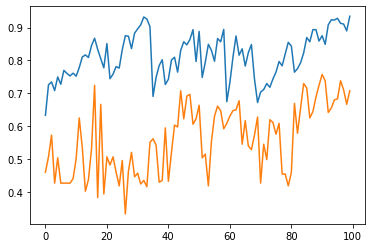

In [69]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

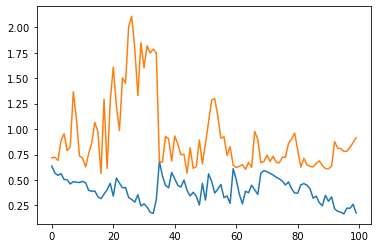

In [70]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

## 시티랩스 250 30일 20%

In [117]:
df = pd.read_csv('./data/적자기업모델데이터/시티랩스_모델데이터_scaler.csv',index_col=0)

X, Y = model_xy(df,window_size=250, target_size=30, rapid_rate=0.15)

In [118]:
X.shape

(1663, 250, 22)

In [119]:
train_test_split = 1300

x_train = X[:1300]
y_train = Y[:1300]

x_test = X[1300:]
y_test = Y[1300:]

In [120]:
with tf.device('/GPU:0'):
    model2 = Sequential()
    model2.add(LSTM(50, input_shape=(250,22)))
    model2.add(Dense(1,activation='sigmoid'))
    model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                14600     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________


In [121]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', metrics ='accuracy', optimizer=Adam)
hist2 = model2.fit(x_train, y_train, epochs=100, batch_size= 10, validation_data= (x_test,y_test))

Epoch 1/100
130/130 [==============================] - 2s 12ms/step - loss: 0.4775 - accuracy: 0.7946 - val_loss: 0.6135 - val_accuracy: 0.7080
Epoch 2/100
130/130 [==============================] - 1s 10ms/step - loss: 0.4867 - accuracy: 0.8008 - val_loss: 0.6675 - val_accuracy: 0.7080
Epoch 3/100
130/130 [==============================] - 1s 10ms/step - loss: 0.4868 - accuracy: 0.8000 - val_loss: 0.7161 - val_accuracy: 0.7080
Epoch 4/100
130/130 [==============================] - 1s 9ms/step - loss: 0.4678 - accuracy: 0.8023 - val_loss: 0.5861 - val_accuracy: 0.7080
Epoch 5/100
130/130 [==============================] - 1s 10ms/step - loss: 0.4458 - accuracy: 0.8115 - val_loss: 0.7106 - val_accuracy: 0.7080
Epoch 6/100
130/130 [==============================] - 1s 10ms/step - loss: 0.4383 - accuracy: 0.8085 - val_loss: 0.7215 - val_accuracy: 0.7080
Epoch 7/100
130/130 [==============================] - 1s 10ms/step - loss: 0.4315 - accuracy: 0.8115 - val_loss: 0.6561 - val_accuracy: 

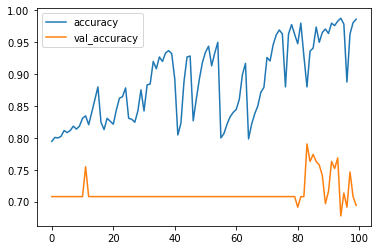

In [122]:
result_acc(hist2)

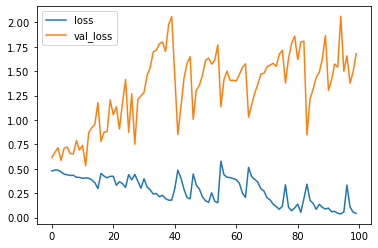

In [123]:
result_loss(hist2)

In [124]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## 시티랩스 500 10일 10%

In [125]:
df = pd.read_csv('./data/적자기업모델데이터/시티랩스_모델데이터_scaler.csv',index_col=0)

X, Y = model_xy(df,window_size=500, target_size=10, rapid_rate=0.1)

In [126]:
X.shape

(1433, 500, 22)

In [127]:
train_test_split = 1300

x_train = X[:1300]
y_train = Y[:1300]

x_test = X[1300:]
y_test = Y[1300:]

with tf.device('/GPU:0'):
    model3 = Sequential()
    model3.add(LSTM(50, input_shape=(500,22)))
    model3.add(Dense(1,activation='sigmoid'))
    model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                14600     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________


In [128]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', metrics ='accuracy', optimizer=Adam)
hist3 = model3.fit(x_train, y_train, epochs=100, batch_size= 10, validation_data= (x_test,y_test))

Epoch 1/100
130/130 [==============================] - 3s 17ms/step - loss: 0.4757 - accuracy: 0.8085 - val_loss: 0.4340 - val_accuracy: 0.8571
Epoch 2/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4555 - accuracy: 0.8169 - val_loss: 0.4063 - val_accuracy: 0.8571
Epoch 3/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4508 - accuracy: 0.8177 - val_loss: 0.3868 - val_accuracy: 0.8571
Epoch 4/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4293 - accuracy: 0.8208 - val_loss: 0.4440 - val_accuracy: 0.8571
Epoch 5/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4301 - accuracy: 0.8238 - val_loss: 0.3921 - val_accuracy: 0.8571
Epoch 6/100
130/130 [==============================] - 2s 14ms/step - loss: 0.3941 - accuracy: 0.8285 - val_loss: 0.5761 - val_accuracy: 0.8571
Epoch 7/100
130/130 [==============================] - 2s 14ms/step - loss: 0.3914 - accuracy: 0.8392 - val_loss: 0.5717 - val_accuracy:

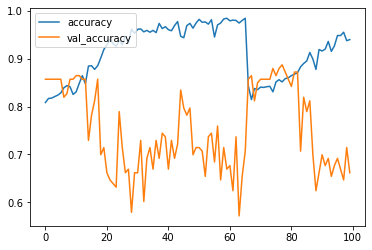

In [129]:
result_acc(hist3)

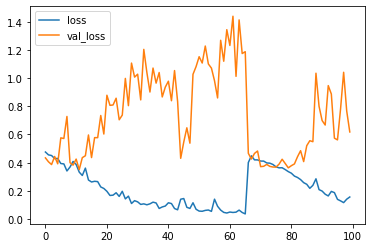

In [130]:
result_loss(hist3)

## 시티랩스 500 20일 10%

In [131]:
df = pd.read_csv('./data/적자기업모델데이터/시티랩스_모델데이터_scaler.csv',index_col=0)

X, Y = model_xy(df,window_size=500, target_size=20, rapid_rate=0.1)

In [132]:
X.shape

(1423, 500, 22)

In [133]:
train_test_split = 1300

x_train = X[:1300]
y_train = Y[:1300]

x_test = X[1300:]
y_test = Y[1300:]

with tf.device('/GPU:0'):
    model4 = Sequential()
    model4.add(LSTM(50, input_shape=(500,22)))
    model4.add(Dense(1,activation='sigmoid'))
    model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                14600     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________


In [134]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='binary_crossentropy', metrics ='accuracy', optimizer=Adam)
hist4 = model4.fit(x_train, y_train, epochs=100, batch_size= 10, validation_data= (x_test,y_test))

Epoch 1/100
130/130 [==============================] - 3s 17ms/step - loss: 0.5924 - accuracy: 0.7015 - val_loss: 0.5760 - val_accuracy: 0.7642
Epoch 2/100
130/130 [==============================] - 2s 14ms/step - loss: 0.5517 - accuracy: 0.6985 - val_loss: 0.6111 - val_accuracy: 0.7642
Epoch 3/100
130/130 [==============================] - 2s 14ms/step - loss: 0.5454 - accuracy: 0.7023 - val_loss: 0.5734 - val_accuracy: 0.7642
Epoch 4/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4870 - accuracy: 0.7254 - val_loss: 0.5867 - val_accuracy: 0.6098
Epoch 5/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4707 - accuracy: 0.7438 - val_loss: 0.5234 - val_accuracy: 0.7642
Epoch 6/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4462 - accuracy: 0.7746 - val_loss: 0.5371 - val_accuracy: 0.7642
Epoch 7/100
130/130 [==============================] - 2s 14ms/step - loss: 0.4103 - accuracy: 0.7946 - val_loss: 0.5557 - val_accuracy:

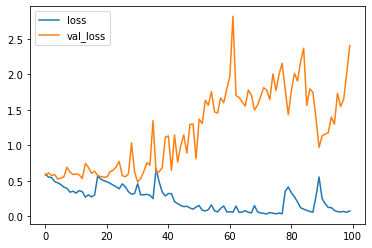

In [135]:
result_loss(hist4)

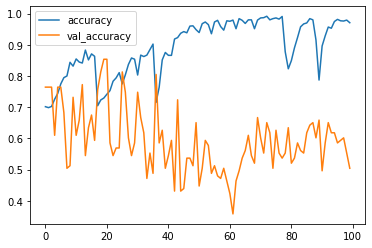

In [136]:
result_acc(hist4)